# MNIST classification

## In this project, we use binary and multi-label classification on the MNIST dataset to predict the input images. MNIST is commonly known as the "hello world" of ML.

### Downloading the dataset

In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)  # to return a numpy array and not a data frame
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

### Description of the dataset

In [2]:
mnist["DESCR"]

"The MNIST database of handwritten digits with 784 features. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  \n\nIt is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image by computing the center of mass of the pixels, and translating the image so as to position this point at the center of the 28x28 field.  \n\nWith some classification methods (particularly template-based methods, such as SV

### Taking a look at the data and target features

In [3]:
X, y = mnist["data"], mnist["target"]
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


(70000,) is equivalent to (70000, 1) <br>
There are 70000 images, and each image has 784 features. Each image is 28 x 28 pixels, and each feature represents one pixel's intensity 0 (white) to 255 (black)

### Visualizing a random number from the dataset

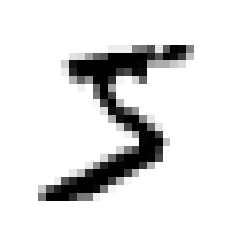

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [5]:
y[0]

'5'

The above image represents the number 5 and this is confirmed by its corresponding label. However, note that y[0] is yielding a string object. We'll have to cast y to an integer object

In [6]:
import numpy as np

y = y.astype(np.uint8)

### Splitting the dataset into train and test before we take a closer peek at the data

In [7]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

The dataet is already shuffled for us. This gurantees that all cross-validation folds will be similar.

## Training a binary classifier

In [8]:
y_train_5 = (y_train == 5) # true for all 5's, false for other digits
y_test_5 = (y_test == 5)

### Training the Stochastic Gradient Descent Classifier

In [9]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [10]:
sgd_clf.predict([some_digit])

array([ True])

The classifier recognizes our initial example image as 5. Now let's evaluate the model's performance

### Performance measures

Using cross_val_score() to evaluate our SGDClassifier model using K-fold cross validation

In [11]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

Using a dumb classifier that just classifies every single image in the "not-5" class

In [12]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
    
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

This is because about 10% of the images in the dataset are 5. So if you guess an image is not 5, you'll be right 90% of the time :) <br>
This demonstrates why accuracy is generally not the preferred performance measure for classifiers.

## Confusion matrix

Confusion matrix is a much better way to evaluate the performance of a classifier. <br>
First let's find the predictions for the train set

In [13]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

Now let's find the confusion matrix

In [14]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

## Precision and recall

Some metrics w.r.t confusion matrix are: Precision, TPR/Recall. <br>
Precision = TP / (TP + FP) <br>
Recall = TP / (TP + FN)

In [15]:
from sklearn.metrics import precision_score, recall_score

print(precision_score(y_train_5, y_train_pred)) # 3530 / (3530 + 687)
print(recall_score(y_train_5, y_train_pred)) # 3530 / (3530 + 1891)

0.8370879772350012
0.6511713705958311


From the precision, we can conclude that when the prediction is a 5, it's truly a 5. However, from recall, we can conclude it only detects 65% of the 5's. <br>
We can combine both the precision and recall metric into a single metric, the F1 score. It's the harmonic mean of both precision and recall.

In [16]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

### Precision/recall trade-off

The threshold can be set to adjust precision and recall accordingly. To find out which threshold to use we need to plot the precision recall curve.

In [17]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                            method="decision_function")

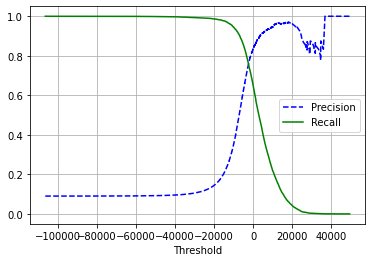

In [18]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_threshold(precisions, recall, threshold):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel('Threshold')
    plt.legend()
    plt.grid()
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

We need to obtain 90% precision for our classifier. To do that, take a look at the plot and find the required threshold to obtain 90% precision. In our case we need to set the threshold at 4000. To be more precise let's search for the threshold using np.argmax()

In [19]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

3370.0194991439557

Now to make the newer predictions with our new threshold, we can just run the following code...

In [20]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

Let's find the new precision and recall scores

In [21]:
print(precision_score(y_train_5, y_train_pred_90))
print(recall_score(y_train_5, y_train_pred_90))

0.9000345901072293
0.4799852425751706


We've obtained a 90% precision classifier. So to create a classifier at a certain precision, just set the threshold. However, precision is not just enough. We need to increase our recall as well. 

## ROC Curve

The receiving operating characteristic (ROC) curve is another common tool used with binary classifiers. It's very similar to the precision/recall curve, but instead of plotting precision versus recall, the ROC curve plots the true positive rate (recall) against the false positive rate (FPR). <br>
FPR: Ratio of negative instances that are incorrectly classified as positive. It's equal to 1 - TNR (True Negative Rate). TNR is also called as specificity.

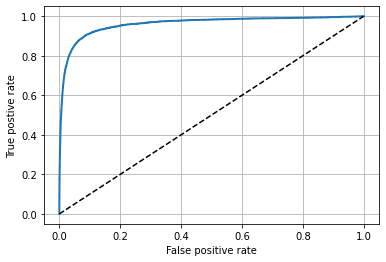

In [22]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.grid()
    plt.xlabel('False positive rate')
    plt.ylabel('True postive rate')
    
plot_roc_curve(fpr, tpr)
plt.show()

One way to compare classifiers is to measure the area under the curve (AUC). A perfect classifier will have a ROC AUC score equal to 1, whereas a purely random classifier will have ROC AUC equal to 0.5.

In [23]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

Choose the PR curve when you care more about the precision (false positives) more . When you need good recall (false negative) use the ROC curve.

### Training a random forest classifier

The random forest classifier does not have a decision_function() method. Instead, it uses predict_proba() method. The predict_proba() method returns an array containing a row per instance and a column per class, each containing the probability that the given instance belongs to the given class. 

In [24]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                   method="predict_proba")

In [25]:
y_scores_forest = y_probas_forest[:, 1] # score = prob. of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

Plotting the ROC curve for both the classfiers, SGD and Random Forest

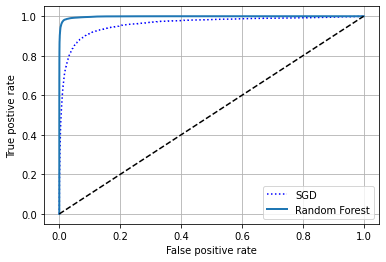

In [26]:
plt.plot(fpr, tpr, 'b:', label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, label="Random Forest")
plt.legend(loc="lower right")
plt.show()

The random forest classifier's ROC curve looks much better compared to the SGD's curve. Let's take a look at the ROC AUC score as well.

In [27]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

Precision and recall scores too...

In [28]:
y_scores_forest = (y_scores_forest >= 0.5)
print(precision_score(y_train_5, y_scores_forest))
print(recall_score(y_train_5, y_scores_forest))

0.9897468089558485
0.8725327430363402


Both, precision and recall scores are high. Therefore, we can say that the RandomForestClassifier is great in binary classification of the MNIST dataset.

## Multiclass classification

Training a SVM (Support Vector Machine) to classify the dataset for 10 classes (0 to 9).

In [29]:
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [30]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

Let's train a SGD classifier now on the MNSIT dataset

In [31]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

Using cross-validation to evaluate the SGDclassifier's accuracy

In [32]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

By scaling the data, we can improve the classifier's accuracy.

In [33]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

In [34]:
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

Able to abtain almost 89% accuracy on an average across the three folds

## Error analysis

Let's find the confusion matrix for the predicted results of the SGDClassifier.

In [35]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

Taking a look at the image representation of the confusion matrix

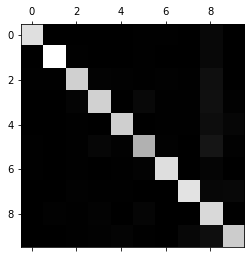

In [36]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

Since most images are on the main diagonal, it means that the classifier was able to classify correctly. But, the 5's look slightly darker than the other digits, which could mean that there are fewer images of 5's in the dataset or that the classifier didn't perform well for 5's. <br>
Let's confirm this by dividing each value in the confusion matrix by the number of images in the corresponding class so that you can compare error rates instead of absolute number of errors.

In [37]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

Filling the diagonals with zero to keep only the errors, and plot the result:

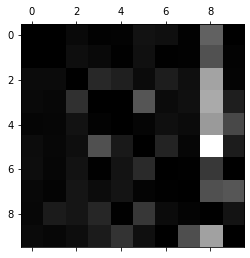

In [38]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

We can clearly see that the column (predicted) for class 8 is bright and almost white for the actual class 5. However for the row (actual) of class 8 it's dark. This indicates that many numbers get misclassified as 8's especially class 5.

## Building a MNIST classifier with over 97% accuracy

In [39]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier()

cross_val_score(knn_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.9676 , 0.9671 , 0.96755])

Let's use GridSearchCV to find the right set of 'weights' and 'n_neighbors' hyperparameter

In [40]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'weights': ['uniform', 'distance'], 'n_neighbors': [3, 4, 5, 6, 7]}
]

grid_search = GridSearchCV(knn_clf, param_grid, cv=3,
                          scoring="accuracy", 
                          return_train_score=True)

grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': [3, 4, 5, 6, 7],
                          'weights': ['uniform', 'distance']}],
             return_train_score=True, scoring='accuracy')

In [41]:
grid_search.best_params_

{'n_neighbors': 4, 'weights': 'distance'}

In [42]:
grid_search.best_estimator_

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [43]:
cvres = grid_search.cv_results_
for accuracy, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(accuracy, params)

0.9681833333333333 {'n_neighbors': 3, 'weights': 'uniform'}
0.9693333333333333 {'n_neighbors': 3, 'weights': 'distance'}
0.9666333333333333 {'n_neighbors': 4, 'weights': 'uniform'}
0.9703500000000002 {'n_neighbors': 4, 'weights': 'distance'}
0.9674166666666667 {'n_neighbors': 5, 'weights': 'uniform'}
0.9686 {'n_neighbors': 5, 'weights': 'distance'}
0.9655 {'n_neighbors': 6, 'weights': 'uniform'}
0.9694833333333334 {'n_neighbors': 6, 'weights': 'distance'}
0.9652 {'n_neighbors': 7, 'weights': 'uniform'}
0.9666666666666667 {'n_neighbors': 7, 'weights': 'distance'}


When we pass the n_neighbors parameter as 4 and weights as distance we are able to obtain just over 97% accuracy.

Now let's evaluate our top classifier on the test set

In [44]:
knn_clf_top = grid_search.best_estimator_

In [45]:
y_test_pred = knn_clf_top.predict(X_test)

In [46]:
conf_mx = confusion_matrix(y_test, y_test_pred)
conf_mx

array([[ 973,    1,    1,    0,    0,    1,    3,    1,    0,    0],
       [   0, 1132,    2,    0,    0,    0,    1,    0,    0,    0],
       [  10,    5,  995,    2,    1,    0,    0,   16,    3,    0],
       [   0,    1,    3,  974,    1,   14,    1,    7,    4,    5],
       [   1,    5,    0,    0,  950,    0,    4,    3,    0,   19],
       [   4,    0,    0,    9,    2,  862,    7,    1,    3,    4],
       [   4,    2,    0,    0,    3,    3,  946,    0,    0,    0],
       [   0,   17,    4,    0,    3,    0,    0,  994,    0,   10],
       [   5,    2,    4,   14,    5,   11,    4,    4,  920,    5],
       [   3,    4,    2,    7,    9,    4,    1,   10,    1,  968]])

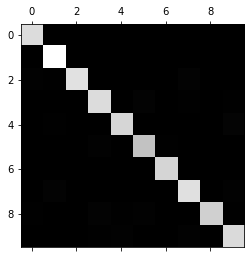

In [47]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [48]:
from sklearn.metrics import accuracy_score

print('Accuracy on the test set: ', accuracy_score(y_test, y_test_pred)*100, '%')

Accuracy on the test set:  97.14 %


## Data augmentation

Let's shift the images in the training set by one pixel in all four directions by one pixel and add all the four augmented images to the training set.

In [55]:
from scipy.ndimage.interpolation import shift

def shift_image(image, dx, dy):
    image = image.reshape((28, 28))
    shifted_image = shift(image, [dy, dx], cval=0, mode="constant")
    return shifted_image.reshape([-1])

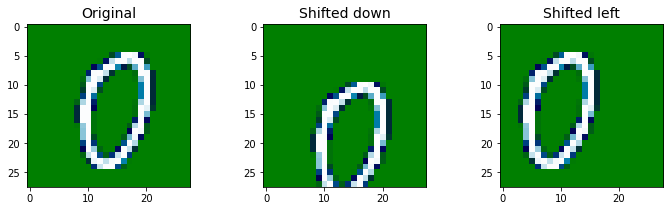

In [57]:
image = X_train[1000]
shifted_image_down = shift_image(image, 0, 5)
shifted_image_left = shift_image(image, -5, 0)

plt.figure(figsize=(12,3))
plt.subplot(131)
plt.title("Original", fontsize=14)
plt.imshow(image.reshape(28, 28), interpolation="nearest", cmap="ocean")
plt.subplot(132)
plt.title("Shifted down", fontsize=14)
plt.imshow(shifted_image_down.reshape(28, 28), interpolation="nearest", cmap="ocean")
plt.subplot(133)
plt.title("Shifted left", fontsize=14)
plt.imshow(shifted_image_left.reshape(28,28), interpolation="nearest", cmap="ocean")
plt.show()

In [59]:
X_train_augmented = [image for image in X_train]
y_train_augmented = [label for label in y_train]

for dx, dy in ((1,0), (-1, 0), (0, 1), (0, -1)):  # shifting right, left, down and up
    for image, label in zip(X_train, y_train):
        X_train_augmented.append(shift_image(image, dx, dy))
        y_train_augmented.append(label)
        
X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

# shuffling the images along the index
shuffle_idx = np.random.permutation(len(X_train_augmented))
X_train_augmented = X_train_augmented[shuffle_idx]
y_train_augmented = y_train_augmented[shuffle_idx]

# training the KNN classifier with the best parameters obtined using GridSearchCV()
knn_clf = KNeighborsClassifier(**grid_search.best_params_)
knn_clf.fit(X_train_augmented, y_train_augmented)

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [60]:
y_pred = knn_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9763

This proves that data augmentation can improve the accuracy.